In [2]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [3]:
%R source('plots/colors.R');

### OmicsPLS

OmicsPLS is currently the only open-source implementation of O2-PLS I am aware of. It is an R package published on CRAN with an accompanying publication in a peer-reviewed journal. It is actively maintained and utilizes latest development standards. However, because it was not used routinely by other researchers (a few citations so far), it was reasonable to perform an attempt to estimate how does the results produced by the package compare to the results reported in the original publication.

In [4]:
%%R
library(OmicsPLS)
source('thirdparty/OmicsPLS_overrides.R');


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



Important functions in OmicsPLS package:
 - o2m_stripped - minimal opls for CV
 - o2m - for analysis
 - crossval_o2m - minimizes the sum of the prediction errors of X and Y
 - crossval_o2m_adjR2 - alternative, proposed by authors, objective: maximize R^2 between T and U.
 
NIPALS is referred to as "alternative" or "power" method; to use it one should set p_thresh=1 (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I would prefer to use NIPALS as it is much faster implementation (~7min vs 1s fro CV), however SVD seems to provide more stable results (demonstrated later).

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.scorer import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GroupKFold, RepeatedKFold, KFold
from pyChemometrics import ChemometricsScaler

from helpers.pls import custom_scorer, format_grid_results
from helpers.o2pls import O2PLS, O2PLSStatistic, r2
from helpers.o2pls import add_grid_metadata, summary_table_for

Note: different rules for CV are used in SIMCA, as explained in "Multi- and Megavariate Data Analysis" Appendix II: Statistics, page 462 (Third revised edition). For predictive components threshold of Q2 > 0.01 is required (among other rules), for orthogonal components PCA rules apply.

A set of statistics will be computed during cross validation for every model:

In [6]:
cv_scoring = {
    name: statistic.calc
    for name, statistic in O2PLSStatistic.statistics.items()
}

In [7]:
%%R
import::here(
    grid_search_plot, grid_orthogonal_components_plot,
    .from='plots/omics_o2pls.R'
)

## Validation of OmicsPLS package implementation and my metrics implementation

In order to validate against the (J. Trygg and S Wold, 2003) O2PLS paper, the same cellulose data (collected at Akzo Nobel). The data were retrieved from ropls package, but it is understood that originally come from "Multivariate calibration using spectral data. Simca tutorial. Umetrics."

In [8]:
%%R -o nirMN -o viscoVn -o classVn
library(ropls)
data(cellulose)
attach(cellulose)
names(cellulose)
nirMN = as.data.frame(nirMN)

In [9]:
nirMN.head(2)

,400,401.75,403.5,405.25,407,...,2493,2494.75,2496.5,2498.25,2500
O1,1.229,1.224,1.219,1.214,1.209,...,0.6109,0.6134,0.6158,0.6183,0.6208
O2,1.237,1.232,1.226,1.221,1.216,...,0.6228,0.6252,0.6276,0.6300,0.6324


The original publication used viscosity (one variable, a vector) as $Y$

Calibration set-validation split in paper was 120:61.

Note: we got only 180, not 181 observations.

In [10]:
nirMN.shape

(180, 1201)

In [11]:
viscoVn = np.atleast_2d(viscoVn).T
viscoVn.shape

(180, 1)

In [12]:
calibartion_X = nirMN[:120]
calibartion_y = viscoVn[:120]
calibartion_X.shape

(120, 1201)

In [13]:
validation_X = nirMN[120:]
validation_y = viscoVn[120:]
validation_X.shape

(60, 1201)

Note: I use validation in two meanings here: the validation subset of the data and the validation of the correctness of the implementations - do not confuse.

They used 7-fold cross-validation:

In [14]:
cellulose_cv_grid_search = partial(
    GridSearchCV,
    cv=KFold(n_splits=7, random_state=0),
    scoring=cv_scoring,
    # we could optimise 'average_cv_predictions', but this is like OPLS
    # and only model of X is of interest here 
    refit='cross_validated_predictions_of_Y',
    iid=True
)

In [15]:
tuned_parameters = [{
    # remember - the second is non inclusive
    'o2pls__joint_components': range(1, 2),
    'o2pls__x_ortho_components': range(0, 6),
    'o2pls__y_ortho_components': [0]
}]

In [16]:
cv_search_cellulose = cellulose_cv_grid_search(make_pipeline(
        O2PLS(algorithm='svd')
    ),
    param_grid=tuned_parameters
)
cv_search_cellulose.fit(calibartion_X, calibartion_y)
cv_search_cellulose.best_params_

{'o2pls__joint_components': 1,
 'o2pls__x_ortho_components': 2,
 'o2pls__y_ortho_components': 0}

In [17]:
grid_results = add_grid_metadata(format_grid_results(cv_search_cellulose))

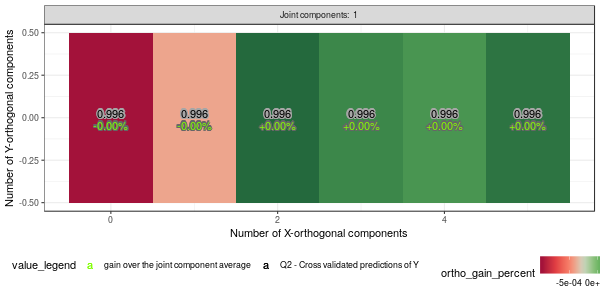

In [18]:
%%R -w 600 -h 300 -i grid_results
grid_orthogonal_components_plot(grid_results, 'cross_validated_predictions_of_Y', 'Q2 - Cross validated predictions of Y')

I explain the high cross-validation values later on in this notebook. This has to do with R2 definition and lack of mean centering.

Note: OmicsPLS implementation of NIPALS is unstable with respect to sign of predictions. I could not pinpoint the issue. Demo:

In [19]:
o2_nipals = O2PLS(
    joint_components=1, x_ortho_components=4, y_ortho_components=0,
    algorithm='nipals'
).fit(calibartion_X, calibartion_y)
o2_nipals.predict_y(validation_X)[:5]

array([[-2159.95293007],
       [-2138.08959112],
       [-2181.14751769],
       [-2174.03557735],
       [-2141.6897352 ]])

Whereas sought values are positive. It flips only after adding the third orthogonal component.

In [20]:
validation_y[:5]

array([[1631],
       [1631],
       [1603],
       [1603],
       [1669]], dtype=int32)

But those are positively correlated nonetheless:

In [21]:
from scipy.stats import spearmanr

spearmanr(o2_nipals.predict_y(validation_X), validation_y)

SpearmanrResult(correlation=0.5304137623676793, pvalue=1.3063233150079833e-05)

Though the Q2 values differ greatly:

In [22]:
o2_nipals.calc_metrics(X=validation_X, Y=validation_y)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,-0.000053,-6.346742,-3.173398


#### Reproducing figure 12b:

In [23]:
def fig_12b(estimator):
    return estimator.y_coefficients.melt(
        var_name='Wavelength region', value_name='b-O2PLS'
    ).convert_objects(convert_numeric=True)

The raw (non-centered, non-scaled) data reproduces the figure well enough:

In [24]:
%R source('helpers/OmicsPLS_overrides.R');
o2_nipals = O2PLS(
    joint_components=1, x_ortho_components=4, y_ortho_components=0,
    algorithm='nipals'
).fit(calibartion_X, calibartion_y)

coefficent_vectors = fig_12b(o2_nipals)

Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection
Calls: <Anonymous> -> <Anonymous> -> withVisible -> source -> file
In addition: Warning messages:
1: In brewer.pal(2, "Set3") :
  minimal value for n is 3, returning requested palette with 3 different levels

2: In file(filename, "r", encoding = encoding) :
  cannot open file 'helpers/OmicsPLS_overrides.R': No such file or directory

Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection
Calls: <Anonymous> -> <Anonymous> -> withVisible -> source -> file


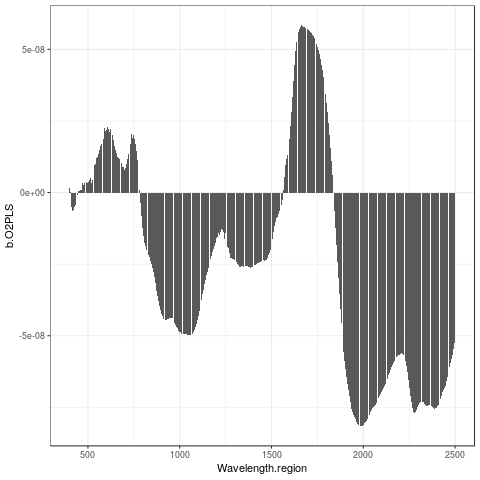

In [25]:
%%R -i coefficent_vectors
(
    ggplot(coefficent_vectors, aes(x=`Wavelength.region`, y=`b.O2PLS`))
    + geom_bar(stat='identity')
    + nice_theme
)

This has a lot of similarities to the original plot. However, the orthogonal correction seems to be slightly worse - the noise remains slightly visible. Maybe they used smoothing? Importantly, the water region is not flipped as in Figure 12a.

However, the metrics indicate very poor fit and predictive abilities:

The internal metrics:

In [26]:
show_table(o2_nipals.calc_metrics())

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,-0.000068,-4.313808,-0.000068,-4.313808,0.000344,0.0,0.000026,1.0


Validation metrics:

In [27]:
show_table(o2_nipals.calc_metrics(X=validation_X, Y=validation_y))

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,-0.000053,-6.346742,-3.173398


Note the very poor prediction of Y - or a very good one but with signs flipped.

#### Using pareto scaling improves the metrics:

In [28]:
%R source('helpers/OmicsPLS_overrides.R');
pareto = ChemometricsScaler(scale_power=0.5, with_mean=False)
o2_nipals = make_pipeline(
    pareto,
    O2PLS(
        joint_components=1, x_ortho_components=4, y_ortho_components=0,
        algorithm='nipals'
    )
)
o2_nipals.fit(calibartion_X, calibartion_y)
o2_nipals = o2_nipals._final_estimator
coefficent_vectors = fig_12b(o2_nipals)

Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection
Calls: <Anonymous> -> <Anonymous> -> withVisible -> source -> file
In addition: Warning message:
In file(filename, "r", encoding = encoding) :
  cannot open file 'helpers/OmicsPLS_overrides.R': No such file or directory

Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection
Calls: <Anonymous> -> <Anonymous> -> withVisible -> source -> file


In [29]:
show_table(o2_nipals.calc_metrics())

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.000024,0.812184,0.000024,0.812184,0.033825,0.0,0.000021,1.0


In [30]:
show_table(o2_nipals.calc_metrics(
    X=pareto.fit_transform(validation_X),
    Y=pareto.fit_transform(validation_y)
))

/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by ChemometricsScaler.
  warnings.warn(msg, DataConversionWarning)
/home/krassowski/.pyenv/versions/3.7.2/envs/meningitis/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by ChemometricsScaler.
  warnings.warn(msg, DataConversionWarning)


,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.000001,-297.657984,-148.828991


But gives a slightly different plot:

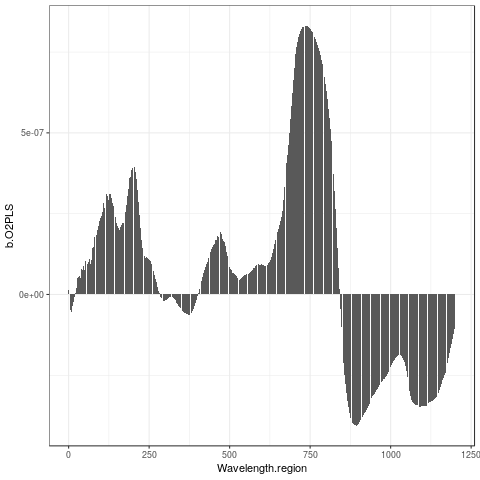

In [31]:
%%R -i coefficent_vectors
(
    ggplot(coefficent_vectors, aes(x=`Wavelength.region`, y=`b.O2PLS`))
    + geom_bar(stat='identity')
    + nice_theme
)

#### Does SVD yields good results?

In [32]:
o2_svd = make_pipeline(
    O2PLS(
        joint_components=1, x_ortho_components=4, y_ortho_components=0,
        algorithm='svd'
    )
)
o2_svd.fit(calibartion_X, calibartion_y)
o2_svd = o2_svd._final_estimator
coefficent_vectors = fig_12b(o2_svd)

In [33]:
show_table(o2_svd.calc_metrics(X=validation_X, Y=validation_y))

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.90253,0.839486,0.871008


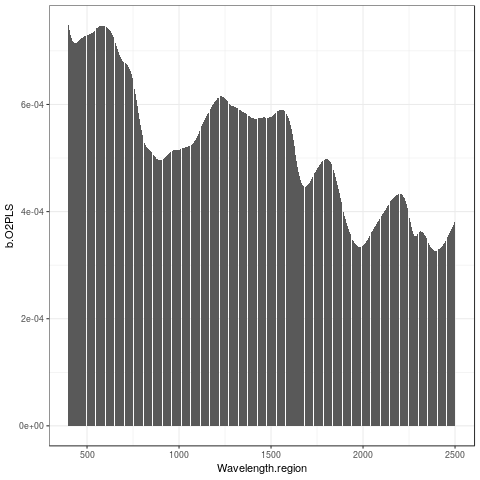

In [34]:
%%R -i coefficent_vectors
(
    ggplot(coefficent_vectors, aes(x=`Wavelength.region`, y=`b.O2PLS`))
    + geom_bar(stat='identity')
    + nice_theme
)

But what seems good in the statistics is not necessarily easily seen:

In [35]:
actual = calibartion_y[:,0]
predicted = o2_svd.predict_y(calibartion_X)[:,0]
df = DataFrame(dict(predicted=predicted, actual=actual)).sort_values('actual').reset_index(drop=True).reset_index()

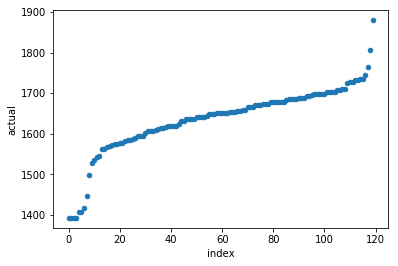

In [36]:
df.plot.scatter(x='index', y='actual');

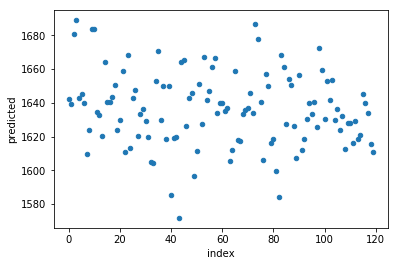

In [37]:
df.plot.scatter(x='index', y='predicted');

In [38]:
from scipy.stats import pearsonr, spearmanr

In [39]:
pearsonr(actual, predicted)

(-0.21401628940538392, 0.018917337878748462)

In [40]:
spearmanr(actual, predicted)

SpearmanrResult(correlation=-0.16128752263615806, pvalue=0.07843080613681683)

### Why is there discrepancy in R2 and the correlation?

This is $R^2_0$, with no intercept, representing fit against a noise rather than a line.

This is different from R2 used in PLS normally!

It is sensitive to the mean centering, and after centering we will get more realistic picture:

In [41]:
pareto = ChemometricsScaler(scale_power=0.5, with_mean=True)
o2_svd = make_pipeline(
    pareto,
    O2PLS(
        joint_components=1, x_ortho_components=4, y_ortho_components=0,
        algorithm='svd'
    )
)
o2_svd.fit(calibartion_X, calibartion_y)
o2_svd = o2_svd._final_estimator

In [42]:
o2_svd.calc_metrics()

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.00013,-0.000276,0.00013,-0.000276,0.000004,0.0,0.269915,1.0


In [43]:
actual = calibartion_y[:,0]
predicted = o2_svd.predict_y(pareto.fit_transform(calibartion_X))[:,0]
df = DataFrame(dict(predicted=predicted, actual=actual)).sort_values('actual').reset_index(drop=True).reset_index()

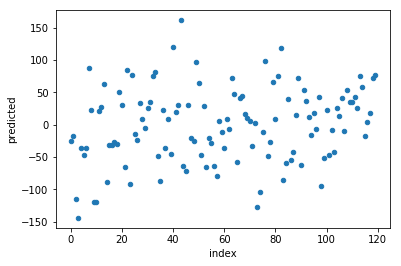

In [44]:
df.plot.scatter(x='index', y='predicted');

In [45]:
pearsonr(actual, predicted)

(0.2678056452590982, 0.0031047558031799174)

In [46]:
spearmanr(actual, predicted)

SpearmanrResult(correlation=0.2040034946106371, pvalue=0.0254230333242249)

See more here: https://stats.stackexchange.com/a/26205/233900

### Comparing statistics from Table IV for O2PLS X model for cellulose example:

In [47]:
summary_table_for(
    grid_results,
    'X', joint_components=1, x_ortho_components=4, y_ortho_components=0
)

$X$ model,$Q^2Y_{hat}$,$R^2X$,$R^2X_{YO}$,$R^2X_{corr}$,$R^2Y_{hat}$
component,,,,,
"n=1, x_orth=0",1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
"n=1, x_orth=1",1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
"n=1, x_orth=2",1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
"n=1, x_orth=3",1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00
"n=1, x_orth=4",1.00 ± 0.00,1.00 ± 0.00,0.00 ± 0.00,1.00 ± 0.00,1.00 ± 0.00


In [48]:
cv_search_cellulose.best_estimator_._final_estimator.calc_metrics(X=validation_X, Y=validation_y)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.90253,0.839544,0.871037


Let's repeat but with mean centering:

In [49]:
cv_search_cellulose = cellulose_cv_grid_search(make_pipeline(
        ChemometricsScaler(with_mean=T),
        O2PLS(algorithm='svd')
    ),
    param_grid=tuned_parameters
)
cv_search_cellulose.fit(calibartion_X, calibartion_y)
cv_search_cellulose.best_params_

{'o2pls__joint_components': 1,
 'o2pls__x_ortho_components': 0,
 'o2pls__y_ortho_components': 0}

In [50]:
grid_results = add_grid_metadata(format_grid_results(cv_search_cellulose))

In [51]:
summary_table_for(
    grid_results,
    'X', joint_components=1, x_ortho_components=4, y_ortho_components=0
)

$X$ model,$Q^2Y_{hat}$,$R^2X$,$R^2X_{YO}$,$R^2X_{corr}$,$R^2Y_{hat}$
component,,,,,
"n=1, x_orth=0",-0.03 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.79 ± 0.09,0.00 ± 0.00
"n=1, x_orth=1",-0.04 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.52 ± 0.11,0.00 ± 0.00
"n=1, x_orth=2",-0.04 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.52 ± 0.12,0.00 ± 0.00
"n=1, x_orth=3",-0.05 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.46 ± 0.13,0.00 ± 0.00
"n=1, x_orth=4",-0.06 ± 0.01,0.00 ± 0.00,0.00 ± 0.00,0.35 ± 0.13,-0.00 ± 0.00


The values of measured statistics (my own code) do not correspond to the values reported in the original publication; possible causes include:
 - differences in implementations (most likely in the orthogonality filter, as no pseudocode was given in the publications - only equations)
 - differences in statistics definitions (the statistics were very carefully defined in the original publication)
 
The negative values are worrying (while R^2 can be negative this should not generally be a case for a good model).

The values computed by the OmicsPLS package depart from those in the original publication as well:

In [52]:
show_table(o2_nipals.r_metrics)

,R2X,R2Y,R2Xcorr,R2Ycorr,R2X_YO,R2Y_XO,R2Xhat,R2Yhat
0,0.006732,1.0,0.000021,1.0,0.00671,0.0,3.681101e-09,0.000172


The exact statistics as computed by me for full model are similar:

In [53]:
show_table(o2_nipals.calc_metrics())

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.000024,0.812184,0.000024,0.812184,0.033825,0.0,0.000021,1.0


For SVD (with pre-scaling and mean centering):

In [54]:
show_table(o2_svd.r_metrics)

,E,Ff,X_hat,Y_hat,R2X,R2Y,R2Xcorr,R2Ycorr,R2X_YO,R2Y_XO,R2Xhat,R2Yhat
0,0.0,0.0,0.0,0.0,0.56812,1.0,0.269915,1.0,0.298205,0.0,0.00013,0.000483


In [55]:
show_table(o2_svd.calc_metrics())

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.00013,-0.000276,0.00013,-0.000276,0.000004,0.0,0.269915,1.0


Given the algorithm description provided in the publication, it seems as the best current reproduction effort. Sadly, the original publication does not provide code, algorithm's details, details on the simulated data nor on the pre-processing steps they used.

#### Comparison to ropls package

However, for standard PLS, the ropls package reproduces the results of the publication almost exactly:

In [56]:
%R import::here(plot_opls, plot_opls_all, plot_summary, run_and_plot_opls, .from='plots/ropls.R')

In [57]:
%%R
pls_nipals = ropls::opls(nirMN, as.matrix(viscoVn), predI=5);

PLS
180 samples x 1201 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y  pQ2
Total    0.991    0.729   0.692   142   5   0 0.05 0.05
dev.new(): using pdf(file="Rplots24.pdf")


O-PLS as implemented in ropls also reproduces the results of the original study with high fidelity:

In [58]:
%%R -o o_nipals
o_nipals = ropls::opls(nirMN, as.matrix(viscoVn), predI=1, orthoI=4);

OPLS
180 samples x 1201 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y  pQ2
Total    0.991    0.729   0.701   142   1   4 0.05 0.05
dev.new(): using pdf(file="Rplots25.pdf")


In [59]:
from types import SimpleNamespace

r_model = o_nipals.slots

opls_model = SimpleNamespace(
    X=nirMN,
    Y=viscoVn,
    T=r_model['scoreMN'],
    U=r_model['uMN'],
    T_Yosc=r_model['orthoScoreMN'],
    P_Yosc=r_model['orthoLoadingMN'],
    W_Yosc=r_model['orthoWeightMN'],
    C=r_model['loadingMN'],
    W=r_model['weightMN'],
    coefficients=r_model['coefficientMN']
)

In [60]:
%%R -o predicted_y
predicted_y = predict(o_nipals, nirMN)

My R squared function produces the same result, as can be seen in ropls results (above):

In [61]:
r2(viscoVn, predicted_y)

0.9916373418086629

This suggests difference between what OmicsPLS calculates and what was presented in the publication.

This is complicated by the fact that the example has single y-vectors - in a publication introducing O2-PLS! - which one could argue that reduces to OPLS. Most certainly the implementation details may lead to different solutions and this seems to be the case here.

Note: While the code for some of the OmicsPLS statistics differ from the published equations, I got very similar results for many statistics.

These differ:
```R
R2X_YO <- (ssq(T_Yosc)/ssq(X_true))
R2Y_XO <- (ssq(U_Xosc)/ssq(Y_true))
```

Publication would suggest:

```R
R2X_YO <- (ssq(T_Yosc @ P_xosc^T)/ssq(X_true))
```

This one:

```R
R2Xhat <- (ssq(U %*% B_U)/ssq(X_true))
R2Yhat <- (ssq(Tt %*% B_T)/ssq(Y_true))
```

should take the difference of prediction and true value in the first term:

```R
R2Xhat <- 1 - (ssq(U %*% B_U - X_true)/ssq(X_true))
R2Yhat <- 1 - (ssq(Tt %*% B_T - Y_true)/ssq(Y_true))
```

And:

```R
R2Xcorr <- (ssq(Tt)/ssq(X_true))
R2Ycorr <- (ssq(U)/ssq(Y_true))
```

should be
    
```R
R2Xcorr <- (ssq(Tt @ W^T)/ssq(X_true))
R2Xcorr <- (ssq(U @ C^T)/ssq(X_true))
```

Other concerns for O2PLS: do the initialization messages:
  > The initialization of the power method lied in a degenerate space
  > Initialization changed and power method rerun

really entail an action or are only just hang out there?

## Further validation on multi-dimensional Y data is required

TODO

(Check against SIMCA; using simulated data was not a success, will need to check on something else)